In [2]:
# -*- coding: utf-8 -*-
import random
import numpy as np
import pandas as pd
import itertools
from scipy.optimize import linprog
import warnings

# ========== 全局配置 ==========
n = 4
n_matrices = 5000
ci_threshold = 0.1
select_count = 50
lambda_param = 0.5            # Model 4 的 λ
tau = 2.0                      # 五级术语 τ=2 → 2τ=4
output_top_only = True         # True: 只导出前50；False: 导出所有满足CI
random.seed(0); np.random.seed(0)

np.seterr(all='ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ========== 工具 ==========
def adjust_val(v: float) -> float:
    """术语值在计算期望/CI时的安全替换：0→0.01；4→3.99"""
    if v <= 0: return 0.01
    if v >= 4: return 3.99
    return float(v)

def softmax(u: np.ndarray) -> np.ndarray:
    u = np.asarray(u, dtype=float)
    u = u - np.max(u)
    ex = np.exp(u)
    s = ex.sum()
    return ex / s if s > 0 else np.ones_like(u)/len(u)

# ========== 1) 生成不完全 PLPR ==========
def generate_matrices(m: int, n: int):
    """
    生成 m 个 n×n 的不完全概率语言偏好矩阵 G。
    - 单元存为 [[idx, prob], ...]，idx∈{0..4}，∑prob=1
    - g_ii = {s2(1.0)}；互反：g_ji 用 (4-idx) 与相同概率
    """
    mats = []
    for _ in range(m):
        G = [[None]*n for _ in range(n)]
        for i in range(n):
            for j in range(i, n):
                if i == j:
                    G[i][i] = np.array([[2, 1.0]])
                else:
                    K = random.randint(1, 5)
                    idx = random.sample(range(5), K)
                    p = np.random.rand(K); p /= p.sum()
                    G[i][j] = np.vstack((idx, p)).T
                    idxij = G[i][j][:,0].astype(int)
                    pij   = G[i][j][:,1]
                    G[j][i] = np.vstack((4 - idxij, pij)).T
        mats.append(G)
    return mats

# ========== 2) 期望矩阵与 CI ==========
triples = list(itertools.combinations(range(n), 3))

def compute_P(G):
    """计算期望矩阵 E（含 0/4 的替换），并夹紧到[0.01,3.99]"""
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            terms = G[i][j][:, 0]
            probs = G[i][j][:, 1]
            vals = np.array([adjust_val(t) for t in terms], dtype=float)
            P[i, j] = float((vals * probs).sum())
    return np.clip(P, 0.01, 3.99)

def compute_CI(G):
    """三元环一致性 CI"""
    P = compute_P(G)
    s = 0.0
    for i, j, k in triples:
        phi = (
            np.log(P[i,j]) + np.log(P[j,k]) + np.log(P[k,i])
            - np.log(P[j,i]) - np.log(P[i,k]) - np.log(P[k,j])
        )
        s += abs(phi)
    denom = 3 * np.math.comb(n, 3) * np.log(n)
    return s / denom

# ========== 3) 生成并筛选 ==========
all_G = generate_matrices(n_matrices, n)
ci_vals = [compute_CI(G) for G in all_G]
candidates = [(k, G) for k,(G,ci) in enumerate(zip(all_G, ci_vals), 1) if ci < ci_threshold]
if not candidates:
    raise RuntimeError(f"没有矩阵满足 CI<{ci_threshold}")

def sort_metric(G):
    """排序指标：行期望和的两两差绝对值之和"""
    P = compute_P(G)
    row_sums = P.sum(axis=1)
    diffs = [abs(row_sums[i] - row_sums[j]) for i in range(n) for j in range(i+1, n)]
    return float(sum(diffs))

# 取前50并重编号 1..K
candidates.sort(key=lambda t: sort_metric(t[1]), reverse=True)
selected = candidates[:select_count] if (output_top_only and len(candidates) >= select_count) else candidates
rank_map = {old_idx: r for r, (old_idx, _) in enumerate(selected, start=1)}
len_selected = len(selected)

# ========== 4) 五种方法（含两种“可变型”LP） ==========
pairs = [(i, j) for i in range(n-1) for j in range(i+1, n)]

# 方法1（可变型LP，两个位置都用 E）
def weights_method1_LP(P, tau=2.0):
    two_tau = 2.0 * tau          # 五级术语时 = 4
    K = len(pairs)
    mvars = n + 2*K

    # 目标: Σ(d^+_{ij} + d^-_{ij})
    c = np.zeros(mvars)
    c[n:n+2*K] = 1.0

    Aeq, beq = [], []

    # 约束1: ∑ w_i = 1
    row = np.zeros(mvars); row[:n] = 1.0
    Aeq.append(row); beq.append(1.0)

    # 约束2: 对每个 i<j
    # (E_ij - 2τ) * w_i + E_ij * w_j - d^+_{ij} + d^-_{ij} = 0
    for p, (i, j) in enumerate(pairs):
        Eij = float(P[i, j])
        row = np.zeros(mvars)
        row[i] = Eij - two_tau        # (E_ij - 2τ) w_i
        row[j] = Eij                  # + E_ij w_j
        row[n + p]     = -1.0         # - d^+_{ij}
        row[n + K + p] =  1.0         # + d^-_{ij}
        Aeq.append(row); beq.append(0.0)

    # 边界: w_i ≥ 0（给一个极小正下界更稳），d^+, d^- ≥ 0
    eps = 1e-12
    bounds = [(eps, None)]*n + [(0, None)]*(2*K)

    res = linprog(c, A_eq=np.array(Aeq), b_eq=np.array(beq),
                  bounds=bounds, method='highs')
    if not res.success:
        return None
    w = res.x[:n]
    w = np.maximum(w, 0)
    s = w.sum()
    return (w/s) if s > 0 else np.ones(n)/n

# —— 方法2：Wang（按公式直接乘积与开 n 次方）
def weights_method2(P):
    n = P.shape[0]
    r = np.zeros(n, dtype=float)
    for i in range(n):
        prod = 1.0
        for j in range(n):
            if i == j:
                continue
            # 按公式：∏_{j=1}^n (E_ij / E_ji)
            prod *= (P[i, j] / P[j, i])
        # 开 n 次方（与公式一致）
        r[i] = prod ** (1.0 / n)
    s = r.sum()
    return (r / s) if s > 0 and np.isfinite(s) else np.ones(n) / n

# 方法3/4/5（Model 4 的可变型LP：用 u=logit 权重，softmax(u) 得 w）
def weights_model5_LP(P, alpha, beta, lam=lambda_param):
    Ebar = np.clip(P/4.0, 1e-6, 1-1e-6)  # 归一化防 log(0)
    lna, lnb = np.log(alpha), np.log(beta)
    K = len(pairs)
    # 变量: [u(0..n-1), δ+(0..K-1), δ-(0..K-1), M]
    mvars = n + 2*K + 1
    M_idx = mvars - 1

    # 目标: λ*(2/(n(n-1)))Σ(δ+ + δ-) + (1-λ)*M
    c = np.zeros(mvars)
    c[n:n+K] = (2.0*lam)/(n*(n-1))
    c[n+K:n+2*K] = (2.0*lam)/(n*(n-1))
    c[M_idx] = (1.0 - lam)

    # 等式: (1/ln a)(u_i - u_j) + (ln Ē_ji - ln Ē_ij)/ln b - δ+ + δ- = 0
    Aeq, beq = [], []
    for p, (i, j) in enumerate(pairs):
        row = np.zeros(mvars)
        row[i] =  1.0 / lna
        row[j] = -1.0 / lna
        row[n + p] = -1.0
        row[n + K + p] = 1.0
        const = (np.log(Ebar[j, i]) - np.log(Ebar[i, j])) / lnb
        Aeq.append(row); beq.append(-const)

    # 锚定一个 u，消除平移自由度
    row = np.zeros(mvars); row[n-1] = 1.0
    Aeq.append(row); beq.append(0.0)

    # 不等式: δ+ + δ- ≤ M
    Aub, bub = [], []
    for p in range(K):
        row = np.zeros(mvars)
        row[n + p] = 1.0
        row[n + K + p] = 1.0
        row[M_idx] = -1.0
        Aub.append(row); bub.append(0.0)

    bounds = [(None, None)]*n + [(0, None)]*(2*K) + [(0, None)]

    res = linprog(c, A_ub=np.array(Aub), b_ub=np.array(bub),
                  A_eq=np.array(Aeq), b_eq=np.array(beq),
                  bounds=bounds, method='highs')
    if not res.success:
        return None
    u = res.x[:n]
    return softmax(u)

# ========== 5) 汇总与输出 ==========
def G_to_str_df(G):
    df = pd.DataFrame(index=range(n), columns=range(n), dtype=object)
    for i in range(n):
        for j in range(n):
            entries = [f"s{int(term)}({prob:.3f})" for term, prob in G[i][j]]
            df.iloc[i,j] = "{" + ",".join(entries) + "}"
    return df

param_sets = {
    'Method3': (np.e, np.e),
    'Method4': (np.e, 2.0),
    'Method5': (5.0,  np.e),
}

records, G_tables, P_tables = [], [], []

for old_idx, G in selected:
    rank = rank_map[old_idx]        # 1..K（筛选后顺序编号）
    P = compute_P(G)

    w1 = weights_method1_LP(P, tau=tau)
    w2 = weights_method2(P)
    if w1 is None:
        continue

    w_m345 = {}
    for name, (a, b) in param_sets.items():
        w = weights_model5_LP(P, alpha=a, beta=b, lam=lambda_param)
        w_m345[name] = w

    if any(w is None for w in w_m345.values()):
        continue

    all_ws = {'Method1': w1, 'Method2': w2, **w_m345}

    for mname, w in all_ws.items():
        w = np.asarray(w)
        rec = {'Matrix_rank': rank, 'Method': mname}
        rec.update({f'w{k+1}': w[k] for k in range(n)})
        # 三个判别力指标
        max_disc = float(np.max(w) - np.min(w))
        sw = np.sort(w)
        min_disc = float(np.min(np.diff(sw))) if n >= 2 else 0.0
        pair_d = [abs(w[i]-w[j]) for i in range(n) for j in range(i+1, n)]
        avg_disc = float(np.mean(pair_d)) if pair_d else 0.0
        rec.update({'max_disc': max_disc, 'min_disc': min_disc, 'avg_disc': avg_disc})
        records.append(rec)

    # 工作表名用 TopXX，更直观
    name = f'Top{rank:02d}'
    G_tables.append((name, G_to_str_df(G)))
    P_tables.append((name, pd.DataFrame(P, dtype=float)))

# ========== 6) 写 Excel ==========
weights_df = pd.DataFrame(records)
if weights_df.empty:
    raise RuntimeError("没有可用结果（可能全部优化失败）。")

weights_df.sort_values(by=['Matrix_rank', 'Method'], inplace=True)

with pd.ExcelWriter('weights_all.xlsx', engine='xlsxwriter') as w:
    weights_df.to_excel(w, index=False, sheet_name='weights')

with pd.ExcelWriter('G_selected.xlsx', engine='xlsxwriter') as w:
    for name, df in G_tables:
        df.to_excel(w, index=False, header=False, sheet_name=name)

with pd.ExcelWriter('P_selected.xlsx', engine='xlsxwriter') as w:
    for name, df in P_tables:
        df.to_excel(w, index=False, header=False, sheet_name=name)

print(f"✅ 输出 {len(G_tables)} 个矩阵（按筛选顺序 1..{len(G_tables)}）；"
      "weights 写入 weights_all.xlsx；G/P 写入 G_selected.xlsx / P_selected.xlsx")


C:\Windows\Temp\ipykernel_18252\2498632362.py:85: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  denom = 3 * np.math.comb(n, 3) * np.log(n)


✅ 输出 50 个矩阵（按筛选顺序 1..50）；weights 写入 weights_all.xlsx；G/P 写入 G_selected.xlsx / P_selected.xlsx


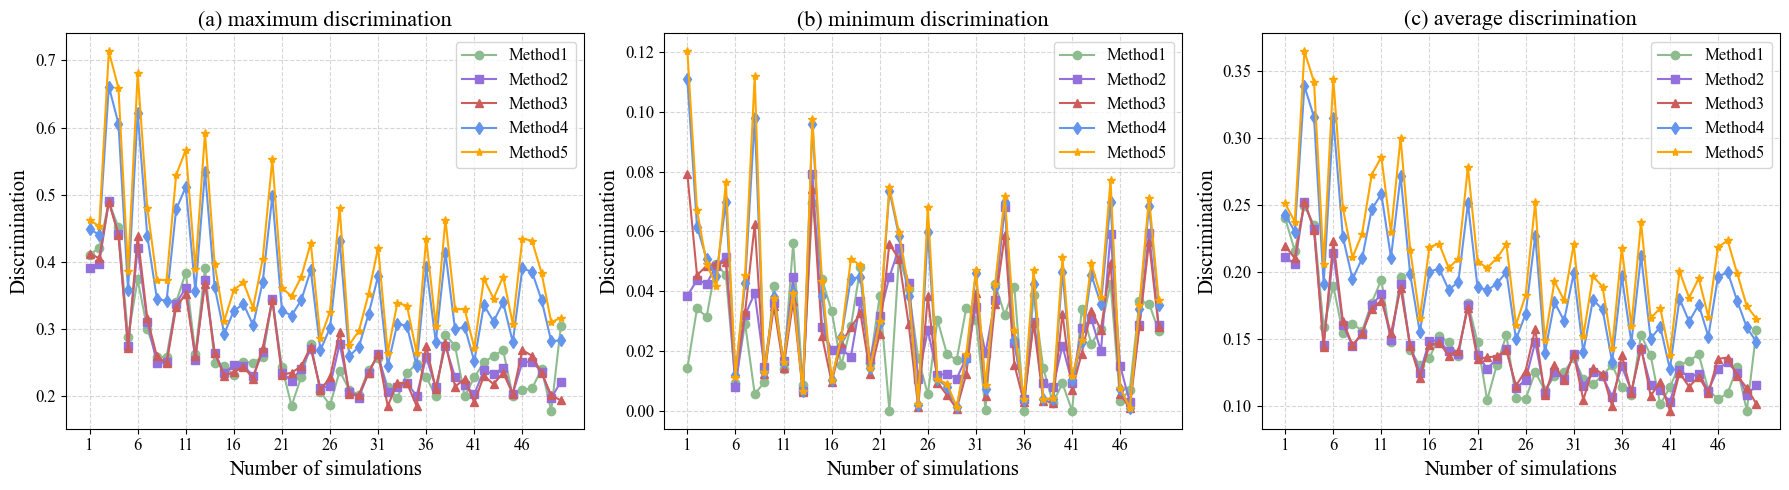

📈 已保存图像 discrimination_plot.png


In [3]:

# ========== 7) 作图 ==========
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'axes.titlesize': 16,
    'axes.labelsize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

methods = ['Method1', 'Method2', 'Method3', 'Method4', 'Method5']
markers = ['o', 's', '^', 'd', '*']
colors  = ['#8FBC8F', '#9370DB', '#CD5C5C', '#6495ED', '#FFA500']

metrics = ['max_disc', 'min_disc', 'avg_disc']
titles  = ['(a) maximum discrimination', '(b) minimum discrimination', '(c) average discrimination']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric, title in zip(axes, metrics, titles):
    pivot = weights_df.pivot(index='Matrix_rank', columns='Method', values=metric)
    xs = sorted(pivot.index.tolist())  # 只显示筛选后的顺序编号
    for m, mk, col in zip(methods, markers, colors):
        if m in pivot.columns:
            y = pivot[m].reindex(xs).values
            ax.plot(xs, y, marker=mk, color=col, label=m, linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel('Number of simulations')
    ax.set_ylabel('Discrimination')
    ax.set_xticks(range(1, len(xs)+1, max(1, len(xs)//10)))
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

plt.tight_layout()
#plt.savefig('discrimination_plot.png', dpi=600)
plt.show()
print("📈 已保存图像 discrimination_plot.png")
